### Fraudes no Cartão de Crédito

In [ ]:
# Fonte: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets


In [4]:

# * Explicações sobre o dataset
 
# O dataset contém transações financeiras, onde a classe "Class" indica se a transação é fraudulenta (1) ou não (0).
# As transações foram realizadas em setembro de 2023 por clientes europeus
# O dataset apresenta transações que ocorreram em 2 dias, onde 492 eram fraudes de um total de 284.807 transações.
# Isso significa que o dataset é altamente desbalanceado, com apenas 0.172% das transações sendo fraudulentas.´

# Contém apenas variáveis numéricas, onde as variáveis V1 a V28 são componentes principais obtidos por PCA (Análise de Componentes Principais) para proteger a privacidade dos clientes.
# As únicas características que não foram transformadas por PCA são "Time" e "Amount".
# A característica tempo contém o número de segundos desde a primeira transação no conjunto de dados.
# A característica valor é o valor da transação

In [5]:
import numpy as np 
import pandas as pd 
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")




In [6]:
df = pd.read_csv('../.csv/creditcard.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Verificar se existem valores nulos 
df.isnull().sum().max()

np.int64(0)

In [9]:
# Verificar nome das colunas
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
print('Não é Fraude', round(df['Class'].value_counts()[0] / len(df) * 100,2), '% do dataset')
print('É Fraude', round(df['Class'].value_counts()[1] / len(df) * 100,2), '% do dataset')

Não é Fraude 99.83 % do dataset
É Fraude 0.17 % do dataset


In [13]:

# * Observações
# o dataframe está desbalanceado, com uma grande quantidade de transações legítimas em comparação com as fraudulentas.
# se usarmos o dataset do jeito que ele está para criar o modelo preditivo e análise, podemos obter muitos erros pois, o algoritmo 
# pode acabar aprendendo a prever apenas a classe majoritária (não fraude) e ignorando a classe minoritária (fraude).

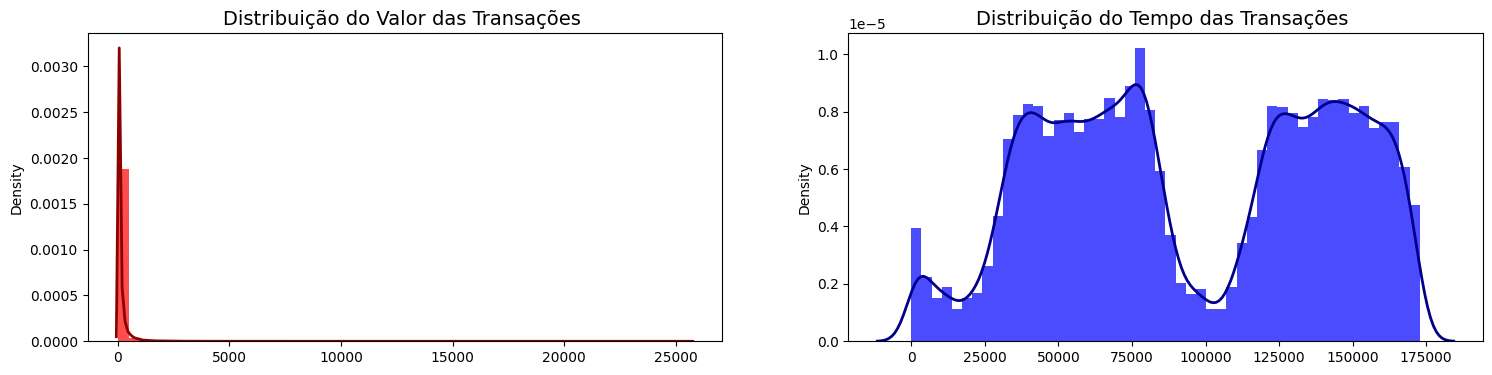

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

# Histograma + KDE manual
ax[0].hist(amount_val, bins=50, density=True, alpha=0.7, color='r')
sns.kdeplot(amount_val, ax=ax[0], color='darkred', linewidth=2)
ax[0].set_title('Distribuição do Valor das Transações ', fontsize=14)

ax[1].hist(time_val, bins=50, density=True, alpha=0.7, color='b')
sns.kdeplot(time_val, ax=ax[1], color='darkblue', linewidth=2)
ax[1].set_title('Distribuição do Tempo das Transações ', fontsize=14)

plt.show()

In [ ]:
 
# * Observações Distribuição do Valor das Transações
# O gráfico Distribuição Do Valor das Transações mostra que a maioria das transações apresentam valores baixos e poucas com valores altos.
# Isso gera uma distribuição altamente assimétrica (right-skewed) com uma cauda longa à direita.
# Valores altos são raros mas críticos
# A escala é desbalanceada, muitas transações pequenas e algumas poucas altas. Isso pode distorcer o modelo e exige transformação

# * Observações Distribuição do Tempo das Transações
# O histograma + KDE mostra como as transações estão distribuídas ao longo do tempo. A maioria das transações ocorre em um período específico, com uma queda acentuada fora desse intervalo.
# Normalmente aparecem padrões sazonais ou ciclos diários: períodos com mais atividades (pico) e outros com menos (vales)


In [27]:
# 1. Filtrar apenas transações fraudulentas e ordenar por valor
fraud_transactions = df[df['Class'] == 1].copy()
fraud_by_amount = fraud_transactions.sort_values('Amount', ascending=False)

# 2. Converter Time para horas do dia
fraud_by_amount['Hour'] = (fraud_by_amount['Time'] % 86400) / 3600
fraud_by_amount['Hour_of_Day'] = fraud_by_amount['Hour'].astype(int)

# 3. Mostrar top 20 maiores fraudes
print("TOP 10 MAIORES TRANSAÇÕES FRAUDULENTAS:")
print(fraud_by_amount[['Amount', 'Hour_of_Day', 'Time', 'Class']].head(10))

# 4. Distribuição por hora do dia
print("\nFRAUDES POR HORA DO DIA:")
fraud_hourly = fraud_by_amount['Hour_of_Day'].value_counts().sort_values(ascending=False)
print(fraud_hourly)

TOP 10 MAIORES TRANSAÇÕES FRAUDULENTAS:
         Amount  Hour_of_Day      Time  Class
176049  2125.87           10  122608.0      1
6971    1809.68            2    9064.0      1
249167  1504.93           18  154278.0      1
89190   1402.16           17   62467.0      1
81609   1389.56           16   59011.0      1
95597   1354.25           18   65385.0      1
199896  1335.00           12  133184.0      1
10690   1218.89            5   18088.0      1
249239  1096.99           18  154309.0      1
233258   996.27           16  147501.0      1

FRAUDES POR HORA DO DIA:
Hour_of_Day
2     57
11    53
18    33
17    29
15    26
14    23
4     23
7     23
16    22
23    21
19    19
20    18
3     17
13    17
12    17
21    16
9     16
5     11
1     10
22     9
8      9
6      9
10     8
0      6
Name: count, dtype: int64


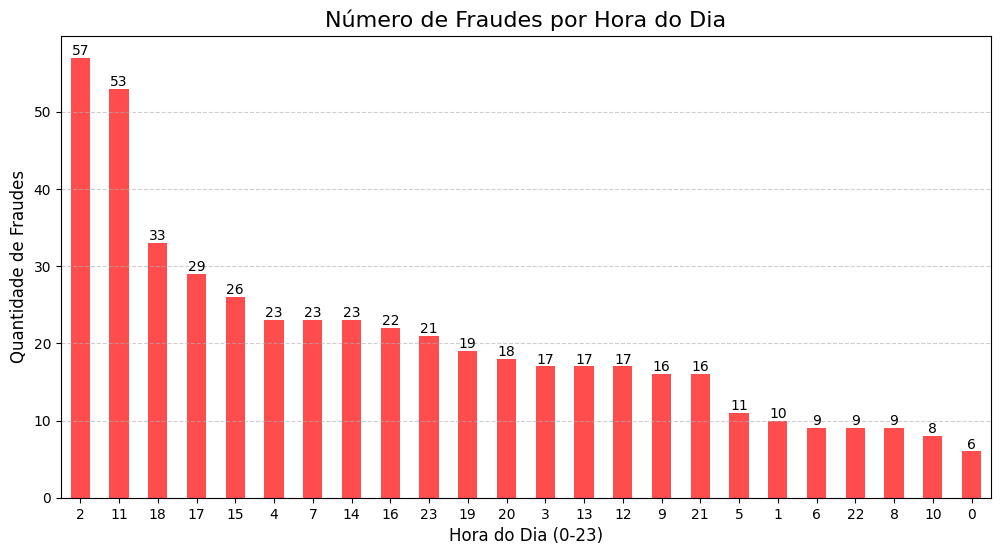

In [34]:

# Ordenar pelo valor em ordem decrescente
fraud_hourly_sorted = fraud_hourly.sort_values(ascending=False)

# Plotar gráfico de barras
ax = fraud_hourly_sorted.plot(kind='bar', figsize=(12,6), color='red', alpha=0.7)

plt.title("Número de Fraudes por Hora do Dia", fontsize=16)
plt.xlabel("Hora do Dia (0-23)", fontsize=12)
plt.ylabel("Quantidade de Fraudes", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar rótulos no topo das barras
for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

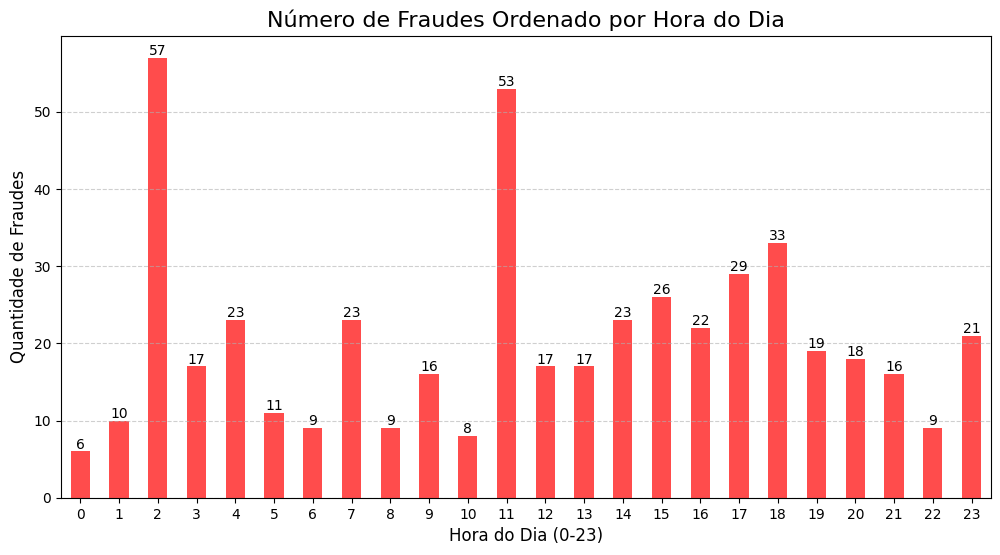

In [42]:

# Ordenar pelo valor em ordem decrescente
fraud_hourly_sorted = fraud_hourly.sort_index()

# Plotar gráfico de barras
ax = fraud_hourly_sorted.plot(kind='bar', figsize=(12,6), color='red', alpha=0.7)

plt.title("Número de Fraudes Ordenado por Hora do Dia", fontsize=16)
plt.xlabel("Hora do Dia (0-23)", fontsize=12)
plt.ylabel("Quantidade de Fraudes", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adicionar rótulos no topo das barras
for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

In [ ]:

# Contagem de fraudes por hora
# fraud_hourly = fraud_by_amount['Hour_of_Day'].value_counts()
# fraud_hourly = fraud_by_amount['Hour_of_Day'].value_counts().sort_values(ascending=False)

# Criar a tabela com contagem e percentual
fraud_table = pd.DataFrame({
    'Hora_do_Dia': fraud_hourly.index,
    'Qtd_Fraudes': fraud_hourly.values,
    'Percentual': (fraud_hourly.values / fraud_hourly.sum() * 100).round(2)
})

# Ordenar pela quantidade de fraudes (decrescente)
fraud_table = fraud_table.sort_values(by='Qtd_Fraudes', ascending=False).reset_index(drop=True)

print(fraud_table)

    Hora_do_Dia  Qtd_Fraudes  Percentual
0             2           57       11.59
1            11           53       10.77
2            18           33        6.71
3            17           29        5.89
4            15           26        5.28
5            14           23        4.67
6             4           23        4.67
7             7           23        4.67
8            16           22        4.47
9            23           21        4.27
10           19           19        3.86
11           20           18        3.66
12            3           17        3.46
13           13           17        3.46
14           12           17        3.46
15           21           16        3.25
16            9           16        3.25
17            5           11        2.24
18            1           10        2.03
19           22            9        1.83
20            8            9        1.83
21            6            9        1.83
22           10            8        1.63
23            0 

In [ ]:

# * Escalonamento e Distribuição
# Nesta etapa vamos escalonar as colunas de tempo e valor
# Também será criado uma subamostra do dataframe original para termos uma quantidade igual de casos de fraude e não fraude
# Dessa forma, o algoritmo consegue entender melhor os padrões que determinam se uma transação é fraude ou não

# * Explicação do motivo de criarmos uma subamostra
# O dataset original é muito desbalanceado
# O desbalanceamento pode causar overfitting, isso significa que o modelo pode assumir que a maioria dos causos não são fraudes
# Correlações erradas: como não sabemos o que são as colunas que estão com V, é útil entender como cada uma delas influencia o resultado.
    # ao ter um dataframe desbalanceado não conseguimos detectar as verdadeiras correlações entre as variáveis



In [44]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Criar escalonadores
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Criar colunas escalonadas
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Remover colunas originais
df.drop(['Time', 'Amount'], axis=1, inplace=True)


In [45]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Hour,Hour_of_Day,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.000000,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.000000,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.000278,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.000278,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.000556,0,0.670579,-0.994960


In [46]:

# * Observações
# Precisamos separar o dataframe original 
# Motivo: queremos testar o modelo no conjunto de teste original e não no conjunto de teste criado pela subamostra
# O objetivo é ajustar o modelo aos dataframes que foram subamostrados e testá-lo no conjunto de teste original

 

In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit

print('Não é Fraude', round(df['Class'].value_counts()[0] / len(df) * 100,2), '% do dataset')
print('É Fraude', round(df['Class'].value_counts()[1] / len(df) * 100,2), '% do dataset')

Não é Fraude 99.83 % do dataset
É Fraude 0.17 % do dataset


In [50]:

X = df.drop(['Class', 'Hour', 'Hour_of_Day'], axis=1)
y = df['Class']


In [53]:

# * Implementar técnica de validação cruzada

# StratifiedKFold é uma versão do K-Fold Cross-Validation. 
# Ele garante que a proporção de classes seja mantida em cada fold
# n_splits = 5, define que o dataset será dividido em 5 partes. Processo de treino e teste será repetido 5 vezes
# random_state=None: Não fixa a semente aleatória. Se você quiser resultados reproduzíveis, deveria colocar um número inteiro aqui (ex: random_state=42).
# shuffle=False: Importante para dados de séries temporais. Significa que os dados não serão embaralhados antes de serem divididos.
# Para detecção de fraude, onde a ordem temporal das transações é importante (treinamos com dados antigos para prever novos), shuffle=False é a escolha correta para evitar data leakage temporal


# O código:
# Dividi os dados em 5 partes.
# Em cada divisão, garante que a proporção de fraudes seja a mesma nos conjuntos de treino e teste.
# Não embaralhar os dados, mantendo a ordem temporal (se X e y já estiverem ordenados por tempo).
# Em cada uma das 5 iterações, você teremos um novo par de (original_Xtrain, original_ytrain) e (original_Xtest, original_ytest) para treinar e testar o modelo.

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [54]:

# * Subamostragem Aleatória
# Nesta fase do projeto, implementaremos a "Subamostragem Aleatória", que consiste basicamente em remover dados para obter um conjunto de dados mais balanceado, evitando assim que nossos modelos sofram overfitting

# * Etapas
# A primeira coisa que precisamos fazer é determinar o quão desbalanceada está nossa classe (use "value_counts()" na coluna "class" para determinar a quantidade de cada rótulo).
# Depois de determinar quantas instâncias são consideradas transações fraudulentas (Fraude = "1"), devemos reduzir as transações não fraudulentas à mesma quantidade de transações fraudulentas (assumindo uma proporção de 50/50). Isso será equivalente a 492 casos de fraude e 492 casos de transações não fraudulentas.
# Após implementar essa técnica, teremos uma subamostra do nosso dataframe com uma proporção de 50/50 em relação às nossas classes. O próximo passo que implementaremos é embaralhar os dados para verificar se nossos modelos conseguem manter uma certa precisão sempre que executarmos este script.
# Observação: o principal problema com a "Subamostragem aleatória" é que corremos o risco de que nossos modelos de classificação não tenham o desempenho tão preciso quanto gostaríamos, pois há uma grande perda de informações (reduzindo 492 transações não fraudulentas de 284.315 transações não fraudulentas).

# * como as classes são altamente assimétricas, devemos torná-las equivalentes para termos um distribuição normal da classe


In [ ]:
# Embaralhar os dados
df = df.sample(frac=1)

# Quantidade de fraudes 492
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Embaralhar as linhas do dataframe
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,Hour,Hour_of_Day,scaled_amount,scaled_time
55115,-0.771932,1.279048,1.084122,-0.433665,0.995625,0.376616,0.720245,0.111110,-0.499819,-0.595612,...,-1.363255,0.299170,0.246842,0.141851,0.121018,0,12.996944,12,-0.294977,-0.445294
189587,0.909124,1.337658,-4.484728,3.245358,-0.417809,-0.762119,-2.506349,0.694164,-0.467556,-4.565260,...,0.325439,0.562766,-0.256278,0.652674,0.319879,1,11.686389,11,0.641375,0.514327
27789,-0.725643,-0.421816,1.952763,-2.673957,0.127493,1.087191,-0.235444,0.158613,-2.409307,0.802398,...,-0.965597,0.055197,-0.193899,-0.164783,-0.173606,0,9.640278,9,-0.167680,-0.587260
150661,-6.185857,7.102985,-13.030455,8.010823,-7.885237,-3.974550,-12.229608,4.971232,-4.248307,-12.965481,...,0.360319,-0.293354,-0.199193,-0.203917,0.398927,1,2.070278,2,0.319989,0.107626
68320,1.036639,0.407227,0.757706,3.161821,-0.568122,0.202181,-0.689804,0.411380,0.336769,-0.283731,...,0.350231,0.507701,0.189621,0.061016,0.063141,1,14.703889,14,-0.296793,-0.373101


In [59]:
print('Distribuição das classes')
print(new_df['Class'].value_counts()/len(new_df) *100)



Distribuição das classes
Class
0    50.0
1    50.0
Name: count, dtype: float64


In [61]:

# * Matrizes de Correlação
# Queremos saber se existem características que influenciam fortemente se uma transação específica é uma fraude. 
# É importante usarmos o dataframe da subamostra para ver quais características têm uma alta correlação positiva ou negativa com relação a transações fraudulentas.

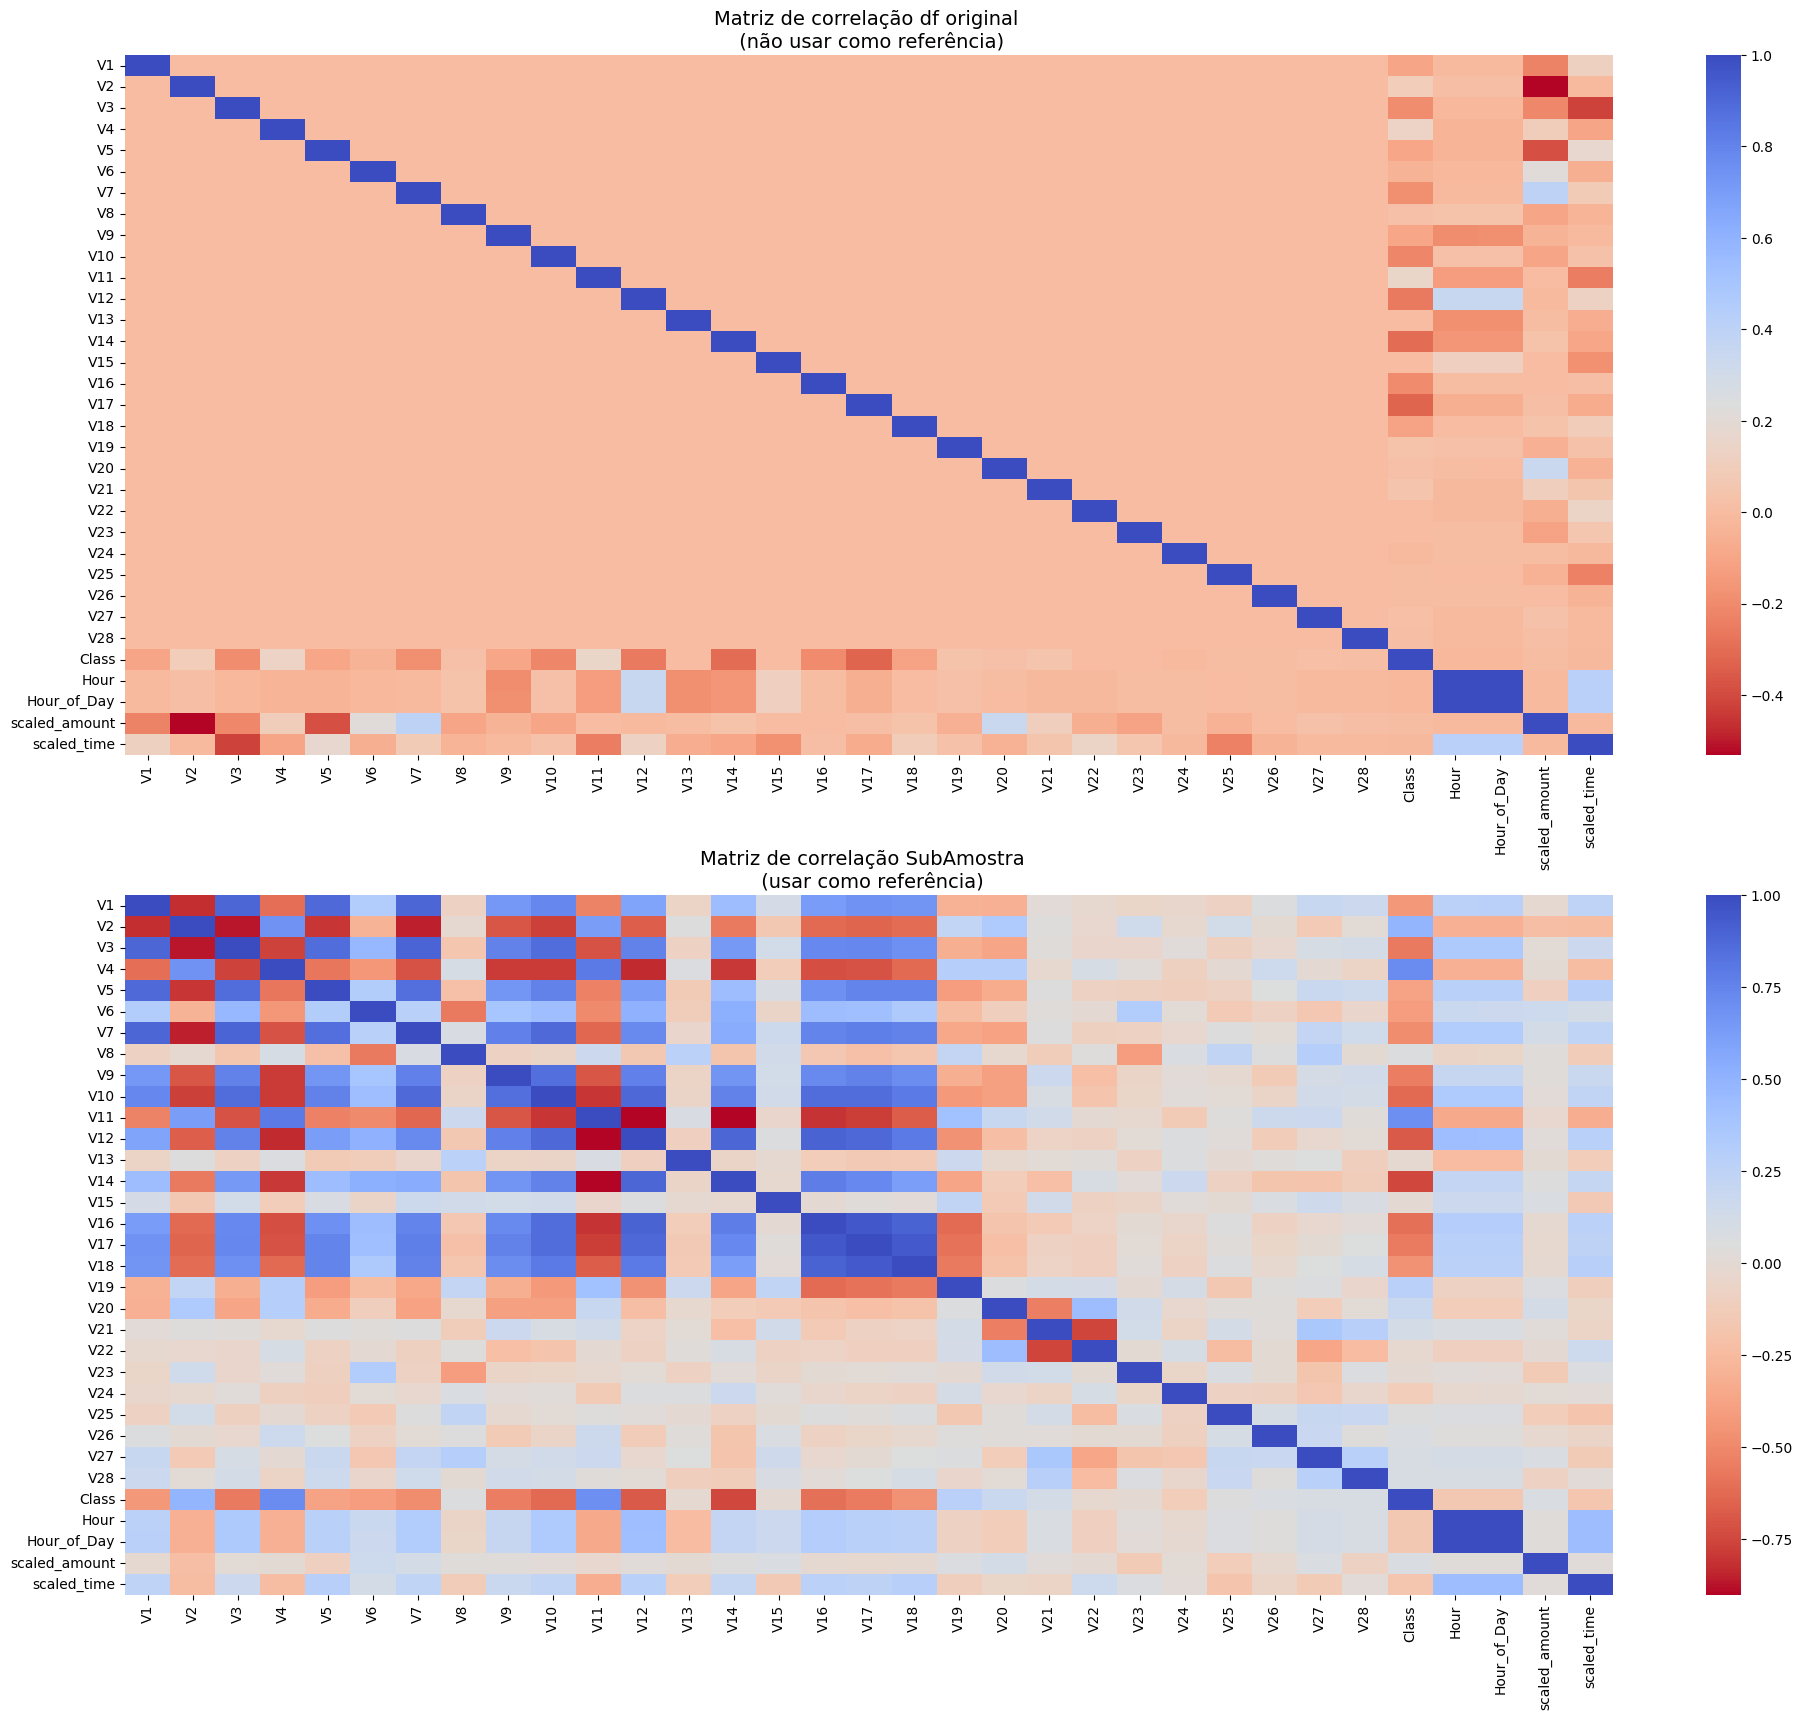

In [63]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# DataFrame Original
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matriz de correlação df original \n (não usar como referência)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Matriz de correlação SubAmostra  \n (usar como referência)', fontsize=14)
plt.show()

In [66]:
# Calcular correlação da variável alvo com todas as features
correlation_with_target = new_df.corr()['Class'].drop('Class')

# Ordenar pelo valor (positivo e negativo) em ordem decrescente
correlation_sorted = correlation_with_target.sort_values(ascending=False)

print("Correlação das variáveis com a variável alvo ('Class'):\n")
print(correlation_sorted)


Correlação das variáveis com a variável alvo ('Class'):

V4               0.711186
V11              0.696637
V2               0.489472
V19              0.272585
V20              0.181985
V21              0.120681
V28              0.092502
V27              0.088536
scaled_amount    0.076303
V26              0.074903
V8               0.058028
V25              0.042757
V23             -0.010460
V15             -0.010777
V13             -0.015356
V22             -0.022788
V24             -0.124349
Hour            -0.166113
Hour_of_Day     -0.166699
scaled_time     -0.176738
V5              -0.382245
V6              -0.409353
V1              -0.427530
V18             -0.457236
V7              -0.480036
V9              -0.549527
V17             -0.557844
V3              -0.563911
V16             -0.598134
V10             -0.629106
V12             -0.682168
V14             -0.748153
Name: Class, dtype: float64


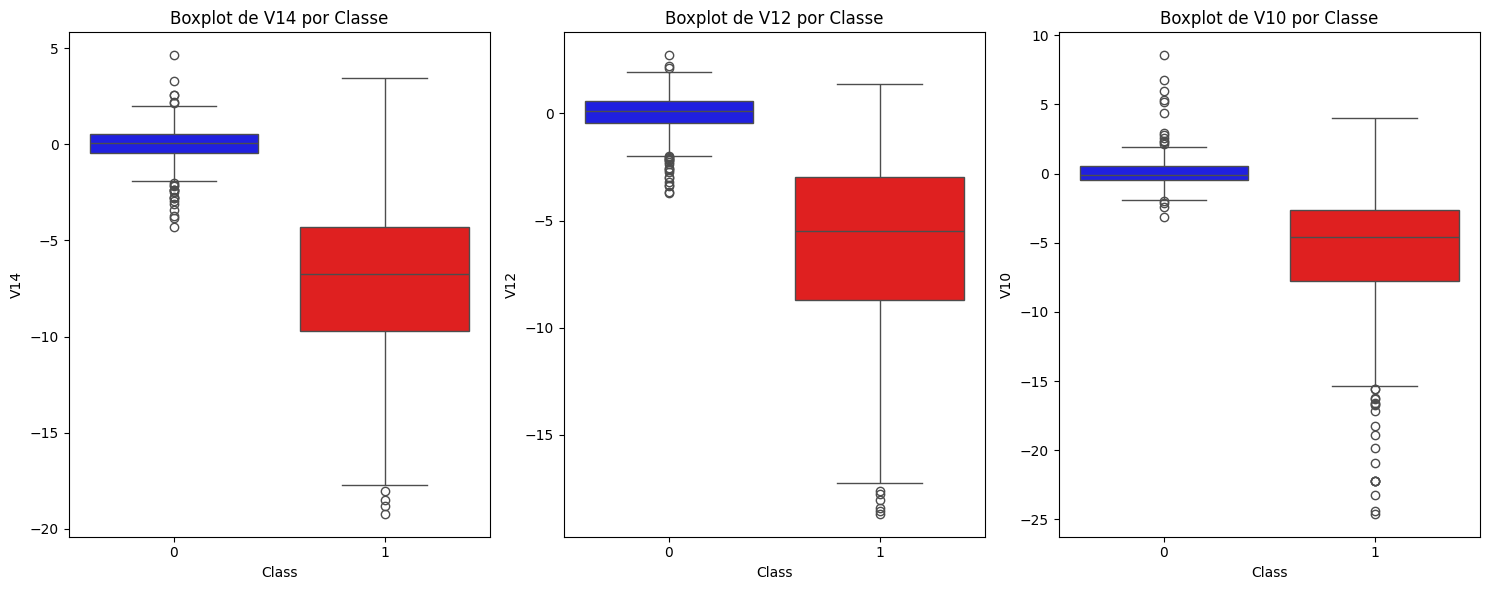

In [ ]:

# Boxplot das 3 variáveis com correlação negativa mais forte
features = ['V14', 'V12', 'V10']

plt.figure(figsize=(15,6))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Class', y=feature, data=new_df, palette=['blue', 'red'])
    plt.title(f'Boxplot de {feature} por Classe')

plt.tight_layout()
plt.show()

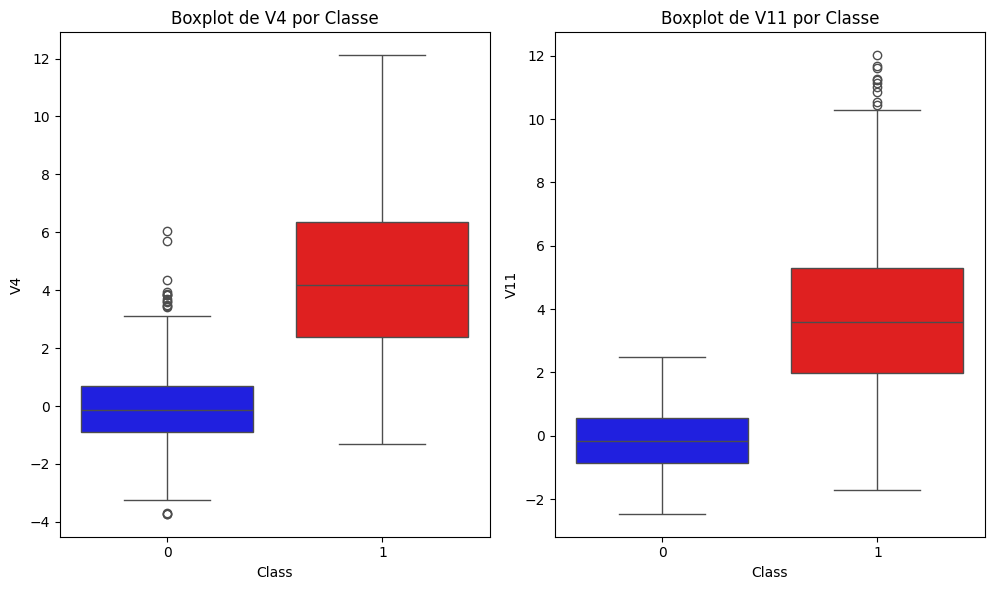

In [70]:
# Boxplot das 3 variáveis com correlação negativa mais forte
features = ['V4', 'V11']

plt.figure(figsize=(15,6))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Class', y=feature, data=new_df, palette=['blue', 'red'])
    plt.title(f'Boxplot de {feature} por Classe')

plt.tight_layout()
plt.show()

In [ ]:

# * Remover outliers
# O objetivo é remover outliers extremos de recursos que tenham alta correlação com nossas classes.
# Isso terá um impacto positivo na precisão do modelo
# * Foram removidas as variáveis V14, V12 e V10 pois, têm maior correlação negativa com a variável alvo ('Class')
# Fazem o modelo encontrar relações que não generalizam
# Podem influenciar de forma desproporcional o ajuste 

In [71]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[np.float64(-19.2143254902614), np.float64(-18.8220867423816), np.float64(-18.4937733551053), np.float64(-18.0499976898594)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [np.float64(-18.6837146333443), np.float64(-18.5536970096458), np.float64(-18.0475965708216), np.float64(-18.4311310279993)]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lo

In [ ]:

# * Aplicar o algoritmo t-SNE
# Depois de aplicar a remoção dos outliers, vamos aplicar o algoritmo t-SNE para visualizar os dados em 2D.
# Verificar a capacidade dos dados de formar grupos (clusters)
# * Se ao aplicar o t-SNE, os dados se agruparem de forma significativa, isso indicaria que as características selecionadas são relevantes para a separação das classes.
# * Caso contrário, pode ser necessário revisar as características utilizadas ou considerar a inclusão de novas variáveis.



In [74]:
remover_colunas = ['Class', 'Hour', 'Hour_of_Day']

X = new_df.drop(remover_colunas, axis=1)
y = new_df['Class']

# T-SNE 
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE levou {:.2} s".format(t1 - t0))

# PCA 
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA levou {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD levou {:.2} s".format(t1 - t0))

T-SNE levou 3.2 s
PCA levou 0.009 s
Truncated SVD levou 0.0025 s


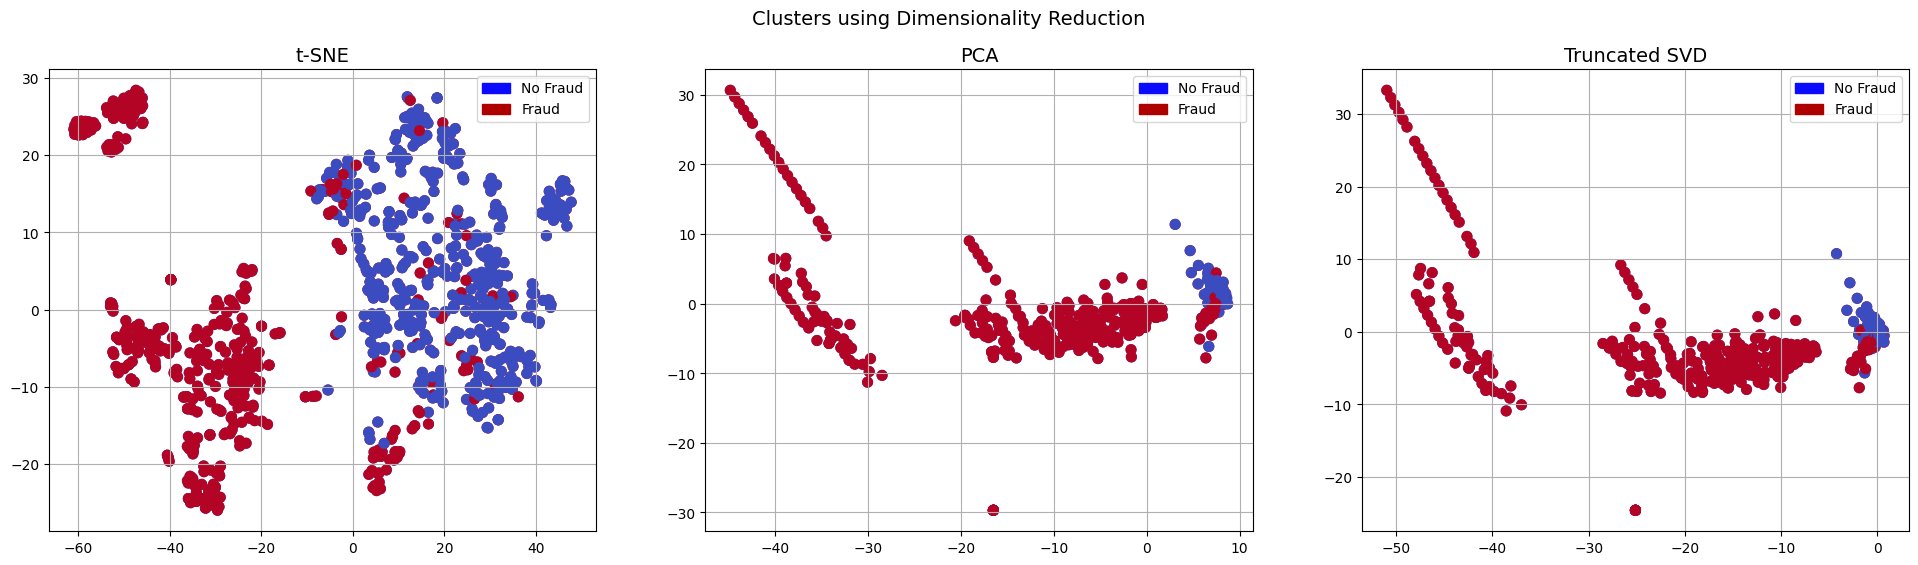

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:

# * Interpretação do gráfico t-SNE
# os clusters têm uma boa separação
# Grupo grande de pontos azuis (não fraudes).
# Conjuntos vermelhos (fraudes) formando “ilhas” com bastante distinção dos azuis.
# Isso mostra que o t‑SNE conseguiu capturar padrões não lineares dos dados.
# existe uma estrutura intrínseca que diferencia fraudes e não fraudes.
# significa que modelos supervisionados (classificadores) provavelmente terão facilidade em encontrar fronteiras de separação.

# * PCA
# Os pontos ainda apresentam alguma separação, mas está muito mais misturada.
# Azul e vermelho se sobrepõem em várias regiões.
# Como PCA é linear, ele busca direções que maximizam a variância total, mas não foi projetado para separar classes desbalanceadas.
# PCA é útil para reduzir dimensionalidade e acelerar modelos, mas não é ótimo para visualização da separabilidade de classes nesse caso.

# * Truncated SVD
# Parecido com PCA, porque também é linear.
# Clusters vermelhos dominam a distribuição, e os pontos azuis ficam mais “colados” no canto direito.
# Mesma limitação: não captura bem relações não lineares.
# bom para datasets muito grandes/esparsos, mas não revela a separabilidade que t‑SNE mostrou.

In [76]:

# * Treinar 4 classificadores
# regressão logística
# árvore de decisão
# random forest
# SVM

# o objetivo é comparar qual se adapta melhor ao problema



In [77]:

remover_colunas = ['Class', 'Hour', 'Hour_of_Day']

X = new_df.drop(remover_colunas, axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformar os valores em uma matriz para alimentar os algoritmos de classificação.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Implementar classificadores
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classificadores: ", classifier.__class__.__name__, "Tem uma pontuação de treinamento de", round(training_score.mean(), 2) * 100, "% de precisão")



Classificadores:  LogisticRegression Tem uma pontuação de treinamento de 93.0 % de precisão
Classificadores:  KNeighborsClassifier Tem uma pontuação de treinamento de 94.0 % de precisão
Classificadores:  SVC Tem uma pontuação de treinamento de 93.0 % de precisão
Classificadores:  DecisionTreeClassifier Tem uma pontuação de treinamento de 90.0 % de precisão


In [78]:
from sklearn.model_selection import GridSearchCV


# * Logistic Regression 
# testa penalidades de regularização
    # l1 = lasso (pode zerar coeficientes irrelevantes)
    # l2 = ridge (não zera coeficientes, mas os reduz)
# testa diferentes valores de C (parâmetro de regularização inverso)
    # quanto menor o C, mais forte a regularização
    # quanto maior o C, o modelo fica mais "livre" para ajustar os dados
# best_estimator_ retorna a melhor combinação encontrada, ou seja, a melhor regressão logística para o dataset.
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_



In [79]:

# * K-Nearest Neighbors (KNN)
# Testa diferentes valores de n_neighbors (quantos vizinhos o algoritmo olha para classificar).
# Testa diferentes algoritmos de busca de vizinhos (ball_tree, kd_tree, etc.), que afetam a eficiência do modelo.
# Retorna o melhor KNN ajustado ao dataset.
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_



In [80]:

# * Support Vector Classifier
# Ajusta o parâmetro C (regularização).
# Testa diferentes kernels:
    # linear = fronteira linear.
    # rbf, poly, sigmoid = fronteiras não lineares de complexidade variada.
# Encontra o SVM ideal para separar fraudes de não fraudes no espaço transformado.
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_



In [81]:

# * DecisionTree 
# Testa diferentes critérios de impureza: Gini e Entropia.
# Ajusta a profundidade máxima da árvore (max_depth) controla complexidade e risco de overfitting.
# Ajusta número mínimo de amostras por folha (min_samples_leaf) evita nós com poucas amostras que não generalizam.
# Retorna a melhor árvore configurada.
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [82]:

# divide o conjunto de treino em 5 folds (validação cruzada estratificada)
# Para cada modelo:
    # Treina em 4 folds.
    # Valida no fold restante.
    # Repete 5 vezes.
# Retorna as 5 pontuações (accuracy por padrão).

# * objetivo
# verificar se os modelos generalizam
    # Cross-validation avalia como o modelo se comporta em diferentes partições de treino.
    # Se a pontuação cai muito entre folds → sinal de instabilidade (alta variância).

# Se existe overfitting
    # Um modelo com score muito alto no treino, mas mais baixo na validação cruzada, indica sobreajuste (memoriza os dados).
    # Exemplo: árvore de decisão tende a memorizar, se não tiver restrições.

# Comparar modelos de forma justa
    # Com GridSearch cada modelo está bem configurado.
    # Agora a validação cruzada garante que os resultados não dependem apenas de um único split de treino/teste, mas de múltiplas divisões.

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Score Validação Cruzada: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Score Validação Cruzada: ', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Score Validação Cruzada: ', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Score Validação Cruzada: ', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Score Validação Cruzada:  94.56%
Knears Neighbors Score Validação Cruzada:  93.5%
Support Vector Classifier Score Validação Cruzada:  93.89%
DecisionTree Classifier Score Validação Cruzada:  92.44%


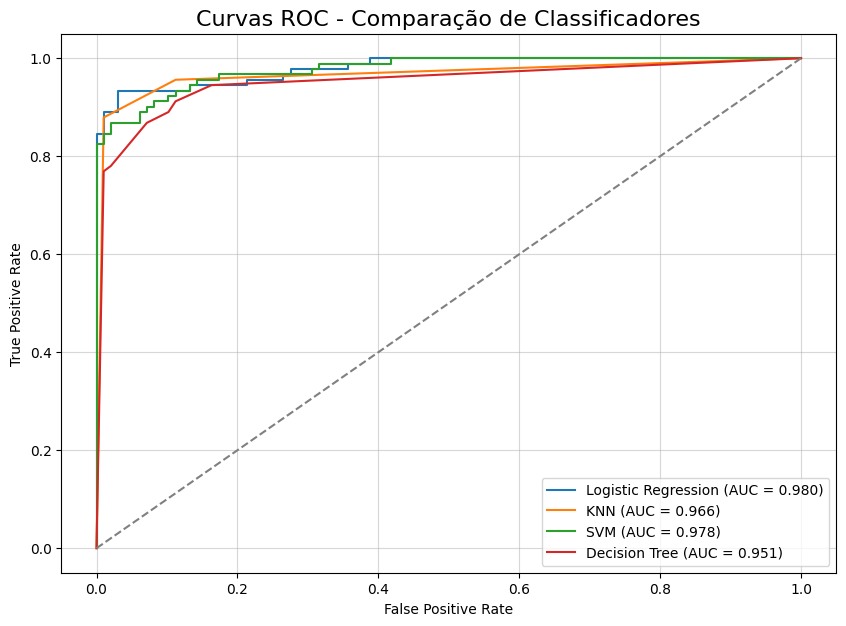

In [84]:
# from sklearn.metrics import roc_curve, roc_auc_score, 
# import matplotlib.pyplot as plt

# Lista de modelos otimizados
models = {
    "Logistic Regression": log_reg,
    "KNN": knears_neighbors,
    "SVM": svc,
    "Decision Tree": tree_clf
}

plt.figure(figsize=(10,7))

for name, model in models.items():
    # Previsões de probabilidade para calcular ROC
    if hasattr(model, "predict_proba"):  
        y_proba = model.predict_proba(X_test)[:,1]
    else:  
        # SVM pode não ter predict_proba dependendo do kernel
        y_proba = model.decision_function(X_test)
    
    # Calcular a curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Linha de referência (classificador aleatório)
plt.plot([0,1], [0,1], linestyle='--', color='gray')

plt.title("Curvas ROC - Comparação de Classificadores", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [85]:
# from sklearn.metrics import classification_report
# import pandas as pd

# Dicionário para armazenar os reports
reports = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports[name] = report['1']  # pegando só a classe "1" (fraude)

# Criar DataFrame para consolidar resultados
df_reports = pd.DataFrame(reports).T  # transpor para ter modelos como linhas
df_reports = df_reports[['precision', 'recall', 'f1-score', 'support']]

print("\nMétricas para Classe Fraude (1):\n")
print(df_reports.round(3))


Métricas para Classe Fraude (1):

                     precision  recall  f1-score  support
Logistic Regression      0.944   0.934     0.939     91.0
KNN                      0.988   0.879     0.930     91.0
SVM                      0.911   0.901     0.906     91.0
Decision Tree            0.919   0.868     0.893     91.0


In [ ]:

# * Relatório de Classificação
# Precision (Precisão): de todas as transações previstas como fraude, qual proporção era realmente fraude.
    # Alta precisão = poucos falsos positivos.
# Recall (Sensibilidade / Revocação): de todas as fraudes reais, qual proporção o modelo conseguiu identificar.
    # Alto recall = poucos falsos negativos.
# F1-score: média harmônica de precisão e recall (balanceia as duas).
    # Se um modelo tem bom equilíbrio entre captura (recall) e exatidão (precision), ele terá F1 alto.
# Support: nº de exemplos da classe fraude no conjunto de teste (91 fraudes no caso).

# * Logistic Regression
# Precision = 0.944 quase todas previsões de fraude foram realmente fraudes (baixo FP).
# Recall = 0.934 identificou 93% de todas as fraudes (pouco FN).
# F1 = 0.939 ótimo equilíbrio entre precisão e recall.
# É o modelo mais balanceado e provavelmente o melhor para produção.

# * KNN
# Precision = 0.988 altíssima precisão (praticamente só acerta quando diz que é fraude).
# Recall = 0.879 porém deixou de detectar ~12% das fraudes (mais falsos negativos).
# F1 = 0.930 ainda muito forte, mas menos equilibrado.
# Melhor para minimizar falsos positivos, mas perde mais fraudes do que a regressão logística.

# * SVM
# Precision = 0.911 (menor precisão da lista).
# Recall = 0.901 também um pouco mais baixo.
# F1 = 0.906 desempenho bom, mas inferior aos outros modelos.
# Serve como base, porém não é competitivo com Regressão Logística ou KNN.

# * Decision Tree
# Precision = 0.919
# Recall = 0.868 (menor entre todos os modelos).
# F1 = 0.893 (também o menor da lista).
# A árvore de decisão pura tende a ser menos estável e mais sujeita a ruído a pior performance comparada aos demais.


# * Conclusão
# * Melhor equilíbrio Regressão Logística (F1 = 0.939)
    # Identifica a maioria das fraudes (alto recall) com poucas falsas alarmes (boa precisão).
    # Ideal para sistemas em que queremos tanto detectar fraudes quanto evitar alarme falso demais.

# * Mais conservador → KNN (Precision = 0.988)
    # Quase sem falsos positivos, mas deixa escapar algumas fraudes.
    # Seria bom em cenários onde custo de falso positivo é muito alto (ex.: bloquear clientes por engano).